# Example 5: Add on site SOC term to wannier90_hr of  Si system.

In [2]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
from tbsoc.lib.lm_expand import MapLmSp, MapLpSm, MapLzSz
from tbsoc.lib.const import Mtrans
from tbsoc.lib.printmat import printsocmat
from tbsoc.lib.read_in import read_poscar_wan_in, read_hr,read_EIGENVAL,read_KPOINTS
from tbsoc.lib.soc_mat import creat_basis_lm,get_matrix_lmbasis,trans_lm_spatial,soc_order,get_mat_soc_orb,get_Hsoc
from tbsoc.lib.cal_tools import hr2hk
from tbsoc.lib.plot_tools import band_plot
from tbsoc.lib.write_hr import write_hr
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
workdir='./'
Lattice, atoms, atom_proj, orbitals, orb_num, orb_type = \
        read_poscar_wan_in(poscarfile = workdir + '/POSCAR',waninfile = workdir+'wannier90.win')

## build the soc matrix.
Msoc={}
for orb in np.unique(orbitals):
    Msoc_orb = get_mat_soc_orb(orb)
    Msoc[orb] = Msoc_orb

num_interaction = len(np.unique(orb_type))
print(u'number of lambda of soc is %d' %num_interaction)

reading POSCAR ...
successfully reading POSCAR ...
reading wannier90.win ...
successfully reading wannier90.win ...
The projections is :
Si 	s 	p 	
Si 	s 	p 	
generating Hsoc mat for porbital in atomic orbital basis
   0.00    0.00    0.00   -1.00    0.00    1.00I

   0.00    0.00    1.00    0.00    1.00I   0.00 

   0.00    1.00    0.00    0.00   -1.00I   0.00 

  -1.00    0.00    0.00    0.00    0.00    1.00I

   0.00   -1.00I   1.00I   0.00    0.00    0.00 

  -1.00I   0.00    0.00   -1.00I   0.00    0.00 

transfer the spin basis form up down up down ... to up up ... down down...
generating Hsoc mat for sorbital in atomic orbital basis
   0.00    0.00 

   0.00    0.00 

transfer the spin basis form up down up down ... to up up ... down down...
number of lambda of soc is 2


In [4]:
hop_spinor, Rlatt, indR0 = read_hr(workdir+'wannier90_hr.dat')
nrpts = hop_spinor.shape[0]
num_wan = 2 * np.sum(orb_num)
if num_wan!=hop_spinor.shape[1]:
    raise ValueError('number of wannier orbitals is wrong!')
print ('The orbital type is: ', orb_type)
print ('The length of lambdas should be %d' %len(np.unique(orb_type)))

reading wannier90_hr.dat ...
successfully reading wannier90_hr.dat ...
The orbital type is:  [0, 1, 0, 1]
The length of lambdas should be 2


In [5]:
lambdas=[0,0.0300625]
Hsoc = get_Hsoc(lambdas,orbitals,orb_type,orb_num,Msoc)

In [6]:
hop_soc = hop_spinor * 1.0
#hop_soc[indR0] += Hsoc

kpath, xpath, xsymm, plot_sbol = read_KPOINTS(Lattice, kpofile = workdir+ '/KPOINTS')
Hksoc=hr2hk(hop_soc,Rlatt,kpath,num_wan)
Hksoc += Hsoc
bandsoc = np.linalg.eigvalsh(Hksoc)
vasp_bands, vasp_kps = read_EIGENVAL(FILENAME=workdir+'/EIGENVAL')


reading KPOINTS ...
GAMMA : [   0.000,   0.000,   0.000] ===>  X : [   0.500,   0.000,   0.500]
X : [   0.500,   0.000,   0.500] ===>  U : [   0.625,   0.250,   0.625]
K : [   0.375,   0.375,   0.750] ===>  GAMMA : [   0.000,   0.000,   0.000]
GAMMA : [   0.000,   0.000,   0.000] ===>  L : [   0.500,   0.500,   0.500]
L : [   0.500,   0.500,   0.500] ===>  W : [   0.500,   0.250,   0.750]
W : [   0.500,   0.250,   0.750] ===>  X : [   0.500,   0.000,   0.500]
successfully reading KPOINTS ...
reading EIGENVAL ...
successfully reading EIGENVAL ...


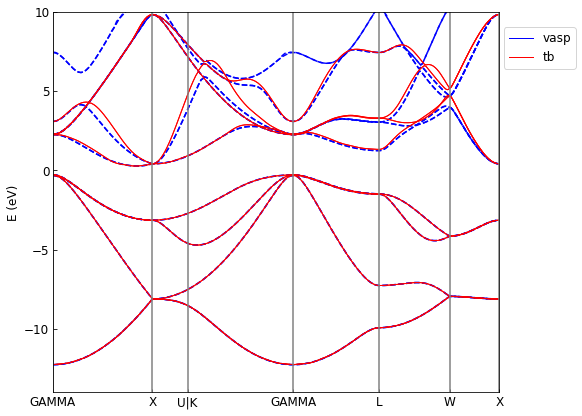

0

In [9]:
#Hknsoc=hr2hk(hop_spinor,Rlatt,kpath,num_wan)
#bandnsoc = np.linalg.eigvalsh(Hknsoc)
EMIN=-14
EMAX= 10
Efermi=6.12880
#band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandnsoc, pl_tb=True, pl_vasp=False, bndvasp=0)
band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandsoc, pl_tb=True,
          pl_vasp=True, bndvasp=vasp_bands,savedir=workdir)


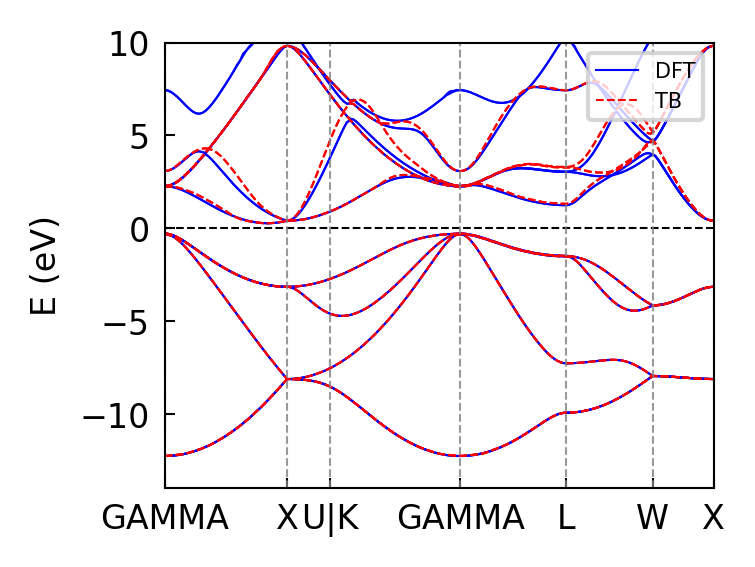

In [13]:
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
lws=0.5
fonts=8
Efermi=6.128800
plt.figure(figsize=(6*0.3937,5*0.3937),dpi=300)
plt.plot(xpath,vasp_bands[:,:]-Efermi,'b-',lw=lws)
plt.plot(xpath,vasp_bands[:,0]-Efermi,'b-',lw=lws,label='DFT')
plt.plot(xpath,bandsoc-Efermi,'r--',lw=lws)
plt.plot(xpath,bandsoc[:,0]-Efermi,'r--',lw=lws,label='TB')
#plt.plot(xpath,vasp_bands_nonsoc[:,0]-Efermi,'r-',lw=lws,label='DFT')
#plt.plot(xpath,vasp_bands_nonsoc[:,:]-Efermi,'r-',lw=lws)

plt.axhline(0,ls='--',lw=lws,c='k')
for ix in xsymm:
    plt.axvline(ix,ls='--',lw=lws,c='gray',alpha=0.8)
plt.xticks(xsymm,plot_sbol)
plt.xlim(xpath[0],xpath[-1])
#plt.xlim(xpath[80],xpath[160])
plt.ylim(-14,10)
plt.legend(loc=1, fontsize=5)
plt.xticks(fontsize=fonts)
plt.yticks(fontsize=fonts)
plt.tick_params(direction='in',length=2.5, width=lws)
plt.ylabel('E (eV)',fontsize=fonts)
#plt.savefig('./band_soc.pdf')
plt.show()

In [67]:
## define a objective function to be optimized.
## here we must know the which band in vasp_bands corresponding to which band in tb_bands
## thus this part is much ad hoc. i just put is here.
## before optimization, we should give a good initial guess of the lambdas. otherwise, the 
## optimization will be much time consuming.
kpath2 = kpath[::2] 
hop_soc = hop_spinor * 1.0
Hksoc = hr2hk(hop_soc,Rlatt,kpath2,num_wan)

def creat_hsoc(lambdas):
    #lambdas=[0.2,0.1]
    # lambdas_soc = lambdas
    lambdas_soc=[0, lambdas[0]]

    Hsoc = get_Hsoc(lambdas_soc,orbitals,orb_type,orb_num,Msoc)
    Hksoc2 = Hksoc + Hsoc
    #kpath, xpath, xsymm, plot_sbol = read_KPOINTS(Lattice, kpofile = workdir+'KPOINTS')
    #kpath2 = kpath[] 
    bandsoc = np.linalg.eigvalsh(Hksoc2)
    picktb = bandsoc[:,:8] * 1.0
    picktb = picktb - np.average(picktb)
    pickvasp = vasp_bands[::2,0:8] * 1.0
    pickvasp = pickvasp - np.average(pickvasp)
    return np.sqrt(np.average((picktb - pickvasp)**2))

In [68]:
# initial guess.
lambdas0 = [0.04]
err = creat_hsoc(lambdas0)
print('initial err is: %10.5f' %err)

res = minimize(creat_hsoc, lambdas0, method='nelder-mead',\
    options={'maxiter':50,'fatol':1e-2,'fatol': 1e-3, 'disp': True})

initial err is:    0.00415
Optimization terminated successfully.
         Current function value: 0.003652
         Iterations: 9
         Function evaluations: 18


In [69]:
res

 final_simplex: (array([[0.0300625],
       [0.03     ]]), array([0.00365224, 0.00365225]))
           fun: 0.0036522370704459286
       message: 'Optimization terminated successfully.'
          nfev: 18
           nit: 9
        status: 0
       success: True
             x: array([0.0300625])

### write the soc hr file


In [ ]:
#  write_hr(workdir,hop_soc,Rlatt)